# GPyOpt: Bayesian Optimization with fixed constrains

### Written by Javier Gonzalez, University of Sheffield.

## Reference Manual index

*Last updated Friday, 11 March 2016.*

In this notebook we will learn how to solve optimization problems with fixed constrains. We will focus on problems where the goal is to find 
$$ x_{M} = \arg \min_{x \in {\mathcal X}} f(x) \,\, \mbox{subject to}, $$

$$c_1(x)\leq 0 $$
$$ \dots $$
$$c_m(x)\leq 0 $$

where $f: {\mathcal X} \to R$ be a L-Lipschitz  continuous function defined on a compact subset ${\mathcal X} \subseteq R^d$ and $c_1,\dots,c_m$ are a series of known constrains that determine the feasible region of the problem. We will see the syntax that we need to use to solve this problems with Bayesian Optimization using GPyOpt. First we start loading GPyOpt and GPy.

In [1]:
%pylab inline
import GPyOpt
import GPy
import numpy as np

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In this example we will optimize the 2D Six-Hump Camel function (available in GPyOpt). We will assume that exact evaluations of the function are observed. The explicit form of the function is:

$$f(x_1,x_2) =4x_1^2 – 2.1x_1^4 + x_1^6/3 + x_1x_2 – 4x_2^2 + 4x_2^4$$

In [2]:
func = GPyOpt.objective_examples.experiments2d.sixhumpcamel()

Imagine that we were optimizing the function in the intervals $(-1,1)\times (-1.5,1.5)$. As usual, we can defined this box constrains as:

In [3]:
space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-1,1)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-1.5,1.5)}]

This will be an standard case of optimizing the function in an hypercube. However in this case we are going to study how to solve optimization problems with arbitrary constrains. In particular, we consider the problem of finding the minimum of the function in the region defined by

$$-x_2 - .5 + |x_1| -\sqrt{1-x_1^2} \leq 0 $$
$$ x_2 + .5 + |x_1| -\sqrt{1-x_1^2} \leq 0 $$

We can define these constrains as

In [4]:
constrains = [{'name': 'constr_1', 'constrain': '-x[:,1] -.5 + abs(x[:,0]) - np.sqrt(1-x[:,0]**2)'},
              {'name': 'constr_2', 'constrain': 'x[:,1] +.5 - abs(x[:,0]) - np.sqrt(1-x[:,0]**2)'}]

And create the feasible region od the problem by writting:

In [5]:
feasible_region = GPyOpt.Design_space(space = space, constraints = constrains)

Now, let's have a look to what we have. Let's make a plot of the feasible region and the function with the original box-constrains. Note that the function .indicator_constrains(X) takes value 1 if we are in the feasible region and 0 otherwise. 

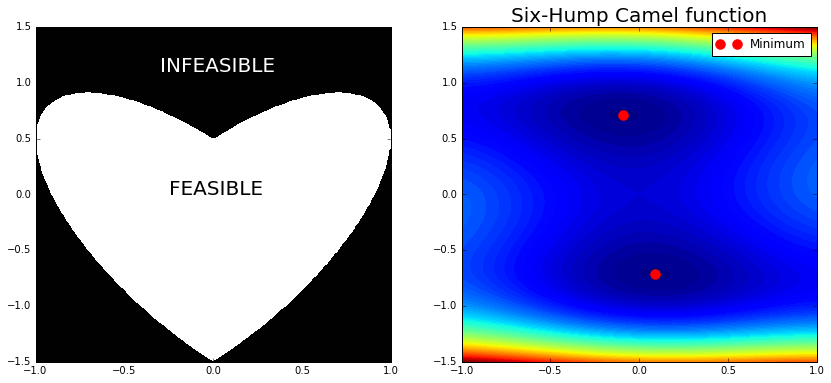

In [6]:
## Grid of points to make the plots
grid = 400
bounds = feasible_region.get_continuous_bounds()
X1 = np.linspace(bounds[0][0], bounds[0][1], grid)
X2 = np.linspace(bounds[1][0], bounds[1][1], grid)
x1, x2 = np.meshgrid(X1, X2)
X = np.hstack((x1.reshape(grid*grid,1),x2.reshape(grid*grid,1)))

## Check the points in the feasible region.
masked_ind = feasible_region.indicator_constraints(X).reshape(grid,grid)
masked_ind = np.ma.masked_where(masked_ind > 0.5, masked_ind)
masked_ind[1,1]=1

## Make the plots
plt.figure(figsize=(14,6))

# Feasible region
plt.subplot(121)
plt.contourf(X1, X2, masked_ind ,100, cmap= plt.cm.bone, alpha=1,origin ='lower')
plt.text(-0.25,0,'FEASIBLE',size=20)
plt.text(-0.3,1.1,'INFEASIBLE',size=20,color='white')

plt.subplot(122)
plt.plot()
plt.contourf(X1, X2, func.f(X).reshape(grid,grid),100, alpha=1,origin ='lower')
plt.plot(np.array(func.min)[:,0], np.array(func.min)[:,1], 'r.', markersize=20, label=u'Minimum')
plt.legend()
plt.title('Six-Hump Camel function',size=20)

The Six-Hump Camel function has two global minima. However, with the constrains that we are using, only one of the two is a valid one. We can see this by overlapping the two previous plots.

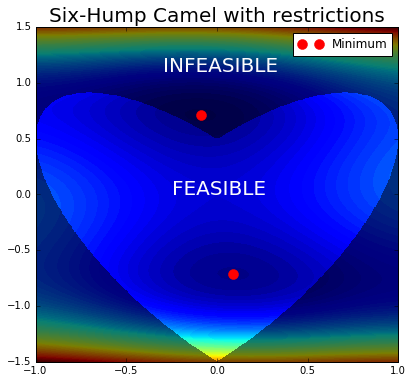

In [7]:
plt.figure(figsize=(6.5,6))
OB = plt.contourf(X1, X2, func.f(X).reshape(grid,grid),100,alpha=1)
IN = plt.contourf(X1, X2, masked_ind ,100, cmap= plt.cm.bone, alpha=.5,origin ='lower')
plt.text(-0.25,0,'FEASIBLE',size=20,color='white')
plt.text(-0.3,1.1,'INFEASIBLE',size=20,color='white')
plt.plot(np.array(func.min)[:,0], np.array(func.min)[:,1], 'r.', markersize=20, label=u'Minimum')
plt.title('Six-Hump Camel with restrictions',size=20)
plt.legend()

We will use the modular iterface to solve this problem. We start by generating an random inital design of 5 points to start the optimization. We just need to do:

In [8]:
# --- CHOOSE the intial design
from numpy.random import seed # fixed seed
seed(123456)

initial_design = GPyOpt.util.stats.initial_design('random', feasible_region, 10)

Importantly, the points are always generated within the feasible region as we can check here:

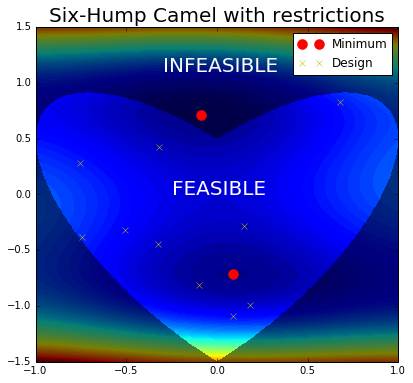

In [9]:
plt.figure(figsize=(6.5,6))
OB = plt.contourf(X1, X2, func.f(X).reshape(grid,grid),100,alpha=1)
IN = plt.contourf(X1, X2, masked_ind ,100, cmap= plt.cm.bone, alpha=.5,origin ='lower')
plt.text(-0.25,0,'FEASIBLE',size=20,color='white')
plt.text(-0.3,1.1,'INFEASIBLE',size=20,color='white')
plt.plot(np.array(func.min)[:,0], np.array(func.min)[:,1], 'r.', markersize=20, label=u'Minimum')
plt.title('Six-Hump Camel with restrictions',size=20)
plt.plot(initial_design[:,0],initial_design[:,1],'yx',label = 'Design')
plt.legend()

Now, we choose the rest of the objects that we need to run the optimization. We will use a Gaussian Process with parameters fitted using MLE and the Expected improvement. We use the default BFGS optimizer of the acquisition. Evaluations of the function are done sequentially.

In [10]:
# --- CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(func.f)

# --- CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

# --- CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

# --- CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

Next, we create the BO object to run the optimization.

In [11]:
# BO object
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)

We first run the optimization for 5 steps and check how the results looks.

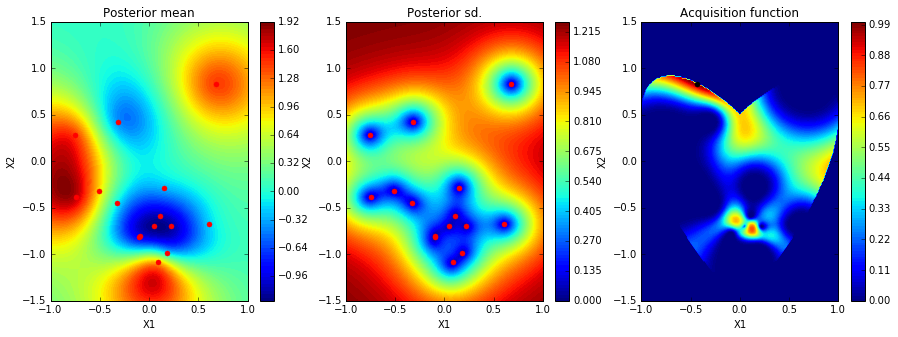

In [12]:
# --- Stop conditions
max_time  = None 
max_iter  = 5
tolerance = 1e-8     # distance between two consecutive observations  

# Run the optimization                                                  
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=False) 
bo.plot_acquisition()

See how the optimization is only done within the feasible region, out of it the value of the acquisition is zero, so no evaluation is selected in that region. We run 20 more iterations to see the acquisition and convergence.

In [13]:
# Run the optimization  
max_iter  = 25
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=False) 

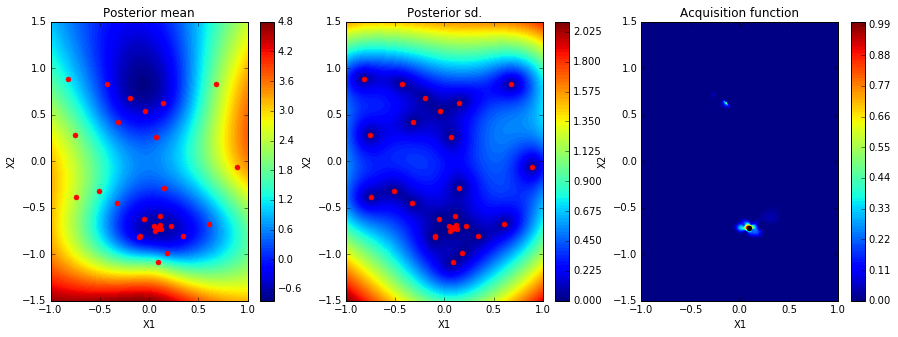

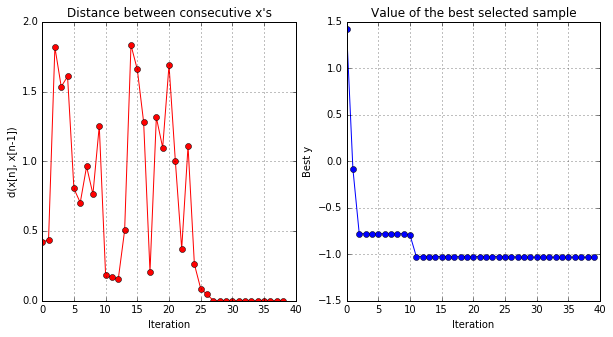

In [14]:
bo.plot_acquisition()
bo.plot_convergence()

In [15]:
# Best found value
np.round(bo.x_opt,2)

array([ 0.09, -0.71])

In [16]:
# True min
np.round(func.min[0],2)

array([ 0.09, -0.71])

Done! problem solved within the fixed domain!